In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPool2D, Bidirectional,AveragePooling2D, LSTM, Reshape ,Input, BatchNormalization, MaxPooling2D, Activation, Flatten, Dense, Dropout
from keras.models import Sequential
from keras.utils import np_utils
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing import image
import scipy
import os
import cv2

In [3]:
data = pd.read_csv('/kaggle/input/fer2013/fer2013.csv')

In [4]:
data

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [5]:
x_data = data['pixels']
y_data = data['emotion']

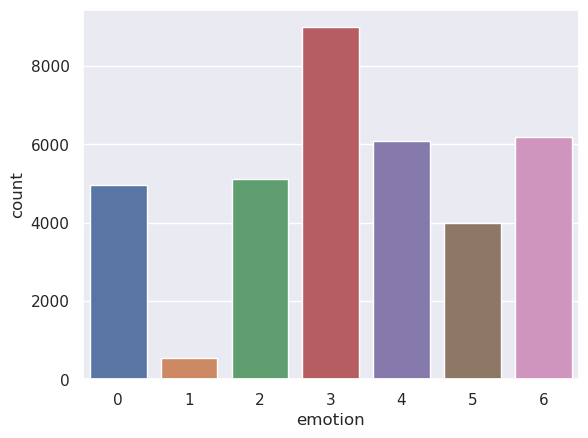

In [6]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="emotion", data=data)

In [7]:
oversampler = RandomOverSampler(sampling_strategy='auto')

x_data, y_data = oversampler.fit_resample(x_data.values.reshape(-1,1), y_data)
print(x_data.shape," ",y_data.shape)

(62923, 1)   (62923,)


In [8]:
y_data.value_counts()

0    8989
2    8989
4    8989
6    8989
3    8989
5    8989
1    8989
Name: emotion, dtype: int64

In [9]:
x_data = pd.Series(x_data.flatten())
x_data

0        70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        151 150 147 155 148 133 111 140 170 174 182 15...
2        231 212 156 164 174 138 161 173 182 200 106 38...
3        24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
                               ...                        
62918    240 241 235 244 236 106 64 94 89 123 138 142 1...
62919    24 23 22 22 19 19 25 25 30 45 61 72 89 99 103 ...
62920    46 41 46 49 39 8 0 1 2 1 2 5 9 13 13 10 13 15 ...
62921    8 4 1 0 2 5 7 9 11 12 18 27 35 39 42 48 55 64 ...
62922    75 81 87 48 52 49 52 55 55 45 53 80 94 109 117...
Length: 62923, dtype: object

In [10]:
x_data = np.array(list(map(str.split, x_data)), np.float32)
x_data/=255
x_data[:10]

array([[0.27450982, 0.3137255 , 0.32156864, ..., 0.41568628, 0.42745098,
        0.32156864],
       [0.5921569 , 0.5882353 , 0.5764706 , ..., 0.75686276, 0.7176471 ,
        0.72156864],
       [0.90588236, 0.83137256, 0.6117647 , ..., 0.34509805, 0.43137255,
        0.59607846],
       ...,
       [0.3019608 , 0.30588236, 0.30980393, ..., 0.49019608, 0.2627451 ,
        0.26666668],
       [0.33333334, 0.32941177, 0.3529412 , ..., 0.22745098, 0.28627452,
        0.32941177],
       [1.        , 0.99607843, 1.        , ..., 0.99607843, 1.        ,
        1.        ]], dtype=float32)

In [11]:
x_data = x_data.reshape(-1, 48, 48, 1)
x_data.shape

(62923, 48, 48, 1)

In [12]:
y_data = np.array(y_data)
y_data = y_data.reshape(y_data.shape[0], 1)
y_data.shape

(62923, 1)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.1, random_state = 45)

In [14]:
x_train.shape

(56630, 48, 48, 1)

In [15]:
model = Sequential([
    Input((48, 48, 1)),
    Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Conv2D(64, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Conv2D(128, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Reshape((-1,128)),
    (LSTM(128)),
    (Reshape((-1,64))),
    LSTM(64),
#     (Reshape((-1,64)))
#     (LSTM(32))    
    Dense(200, activation='relu'),
    Dropout(0.6),
    Dense(7, activation = 'softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 46, 46, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 46, 46, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 46, 46, 64)        0

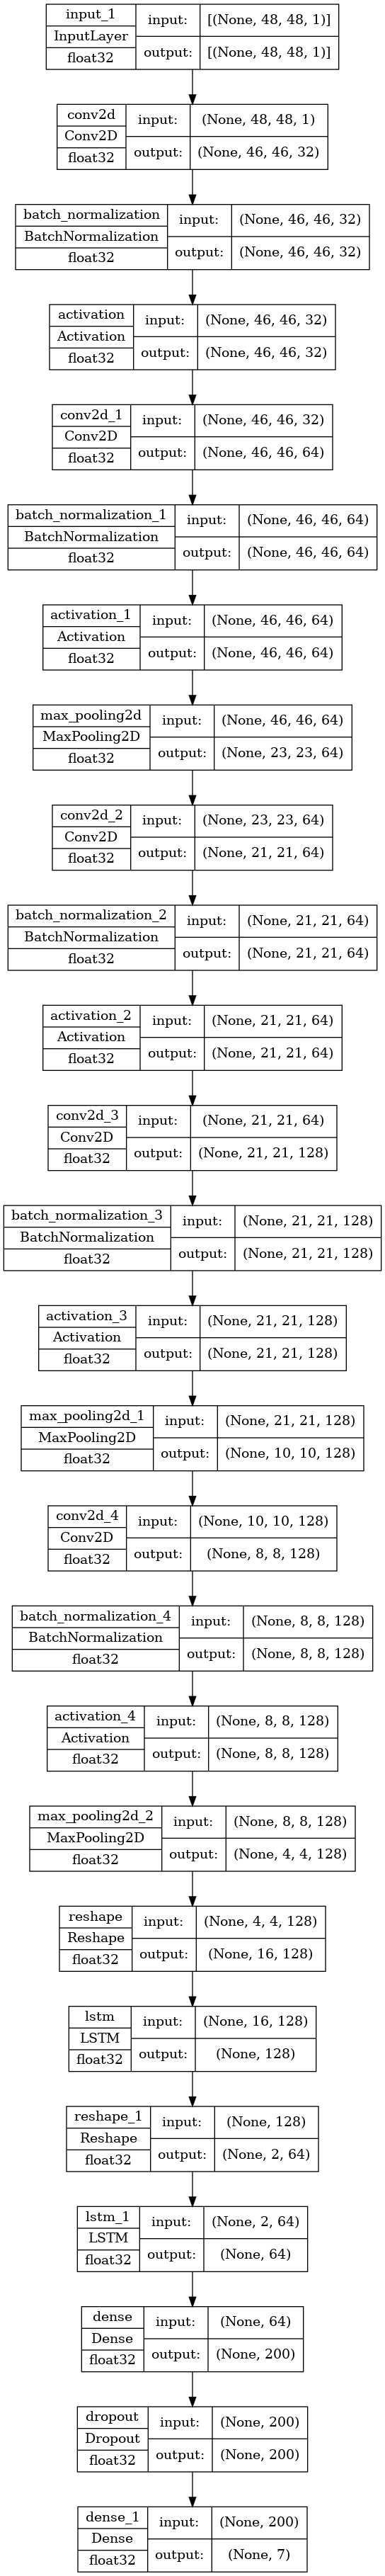

In [16]:
tf.keras.utils.plot_model(model, to_file = "model.png", show_shapes = True, show_dtype = True)

In [17]:
adam = keras.optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
y_train = np_utils.to_categorical(y_train, 7)
y_train.shape

(56630, 7)

In [19]:
y_test = np_utils.to_categorical(y_test, 7)
y_test.shape

(6293, 7)

In [20]:
history = model.fit(x_train, y_train, epochs = 100, validation_data=(x_test, y_test))

Epoch 1/100
1770/1770 [==============================] - 38s 13ms/step - loss: 1.4603 - accuracy: 0.4293 - val_loss: 1.1766 - val_accuracy: 0.5457
Epoch 2/100
1770/1770 [==============================] - 23s 13ms/step - loss: 1.0546 - accuracy: 0.5954 - val_loss: 1.0455 - val_accuracy: 0.5978
Epoch 3/100
1770/1770 [==============================] - 23s 13ms/step - loss: 0.9078 - accuracy: 0.6584 - val_loss: 1.0059 - val_accuracy: 0.6151
Epoch 4/100
1770/1770 [==============================] - 23s 13ms/step - loss: 0.7910 - accuracy: 0.7107 - val_loss: 0.9393 - val_accuracy: 0.6584
Epoch 5/100
1770/1770 [==============================] - 22s 13ms/step - loss: 0.6790 - accuracy: 0.7568 - val_loss: 0.9388 - val_accuracy: 0.6496
Epoch 6/100
1770/1770 [==============================] - 22s 13ms/step - loss: 0.5838 - accuracy: 0.7976 - val_loss: 0.7434 - val_accuracy: 0.7314
Epoch 7/100
1770/1770 [==============================] - 22s 13ms/step - loss: 0.4915 - accuracy: 0.8330 - val_loss: 0

In [21]:
print("Accuracy of our model on validation data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

197/197 [==============================] - 1s 6ms/step - loss: 1.1674 - accuracy: 0.8366
Accuracy of our model on validation data :  83.66438746452332 %


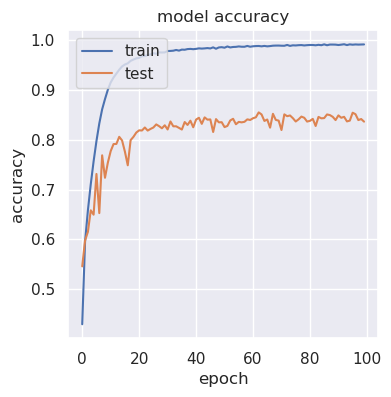

In [22]:

cm = plt.figure(figsize = (4,4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
cm.savefig("model_acc")
plt.show()

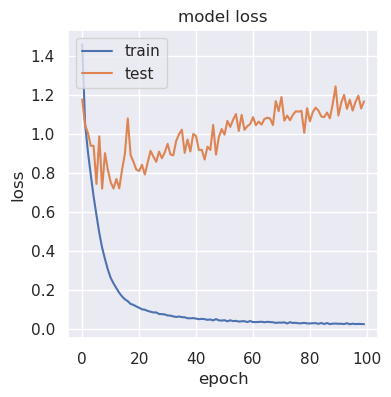

In [23]:
# summarize history for loss
cm = plt.figure(figsize = (4,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
cm.savefig("model_loss")
plt.show()

In [24]:
y_pred = model.predict(x_test)
y_result = []

for pred in y_pred:
    y_result.append(np.argmax(pred))
y_result[:10]

197/197 [==============================] - 2s 4ms/step


[6, 5, 5, 6, 1, 0, 6, 4, 1, 4]

In [25]:
y_actual = []

for pred in y_test:
    y_actual.append(np.argmax(pred))
y_actual[:10]

[6, 5, 5, 6, 1, 0, 3, 4, 1, 3]

In [26]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_actual, y_result))

              precision    recall  f1-score   support

           0       0.84      0.83      0.84       935
           1       1.00      1.00      1.00       895
           2       0.71      0.86      0.78       880
           3       0.87      0.77      0.82       906
           4       0.71      0.75      0.73       888
           5       0.94      0.93      0.93       869
           6       0.82      0.73      0.78       920

    accuracy                           0.84      6293
   macro avg       0.84      0.84      0.84      6293
weighted avg       0.84      0.84      0.84      6293



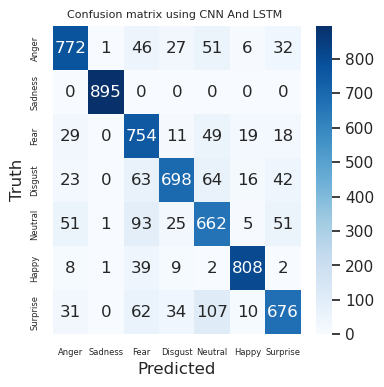

In [27]:
# import seaborn as sn
# cm = tf.math.confusion_matrix(labels = y_actual, predictions = y_result)

# plt.figure(figsize = (6,4))
# sn.heatmap(cm,cmap="Purples", annot = True, fmt = 'd')
# plt.xlabel('Predicted')
# plt.ylabel('Truth')
# plt.savefig("confusion")

import seaborn as sn
cm = tf.math.confusion_matrix(labels = y_actual, predictions = y_result)

plt.figure(figsize = (4,4))
ax = plt.axes()
sn.heatmap(cm,cmap="Blues", annot = True, fmt = 'd')
ax.xaxis.set_ticklabels([  "Anger", "Sadness", "Fear", "Disgust", "Neutral","Happy","Surprise"], fontsize=6);
ax.yaxis.set_ticklabels([  "Anger", "Sadness", "Fear", "Disgust", "Neutral","Happy","Surprise"],  fontsize=6);

plt.title('Confusion matrix using CNN And LSTM ', fontsize = 8, fontweight=500)
plt.xlabel('Predicted')
plt.ylabel('Truth')


plt.savefig("confusion")